In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import dgl
from torch_geometric.datasets.dblp import DBLP
import random
import torch
from torch import optim
import torch_geometric.utils.convert
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns
from collections import Counter
import os
import glob
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original DBLP dataset with all node features

In [3]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [4]:
author_data = data['author'].x
df_author = pd.DataFrame(author_data)
            
X = df_author
col_sum = X.sum(axis=0)
sorted_colsum = sorted(col_sum, reverse=True)
index_list = []
for i in sorted_colsum[:8]:
     index_list.append(list(col_sum).index(i))
imp_feat_author = X[index_list]

In [5]:
paper = data['paper'].x.tolist()
df_paper = pd.DataFrame(paper)
            
X = df_paper
col_sum = X.sum(axis=0)
sorted_colsum = sorted(col_sum, reverse=True)
index_list = []
for i in sorted_colsum[:5]:
     index_list.append(list(col_sum).index(i))
imp_feat_paper = X[index_list]

In [6]:
term_df = pd.DataFrame(data['term'].x.numpy())
corr = term_df.corr()
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.19).any()
real = corr.loc[m]
list_index = np.ravel(real.index).tolist()
imp_feat_term = term_df[list_index]

In [7]:
data['author'].x = torch.tensor(imp_feat_author.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(imp_feat_paper.values).to(dtype=torch.float32)
data['term'].x = torch.tensor(imp_feat_term.values).to(dtype=torch.float32)

DBLP dataset with selected node features used for GNN training

In [8]:
data

HeteroData(
  author={
    x=[4057, 8],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 5] },
  term={ x=[7723, 6] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [9]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])


model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device =  'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 501):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 010, Loss: 0.9693, Train: 0.6325, Val: 0.5400, Test: 0.5947
Epoch: 020, Loss: 0.8073, Train: 0.7050, Val: 0.6100, Test: 0.6319
Epoch: 030, Loss: 0.7248, Train: 0.7325, Val: 0.6125, Test: 0.6356
Epoch: 040, Loss: 0.6434, Train: 0.7750, Val: 0.6225, Test: 0.6491
Epoch: 050, Loss: 0.5718, Train: 0.7925, Val: 0.6450, Test: 0.6466
Epoch: 060, Loss: 0.5036, Train: 0.8125, Val: 0.6325, Test: 0.6442
Epoch: 070, Loss: 0.4440, Train: 0.8275, Val: 0.6300, Test: 0.6408
Epoch: 080, Loss: 0.3911, Train: 0.8650, Val: 0.6200, Test: 0.6352
Epoch: 090, Loss: 0.3475, Train: 0.8750, Val: 0.6100, Test: 0.6285
Epoch: 100, Loss: 0.3030, Train: 0.8925, Val: 0.6050, Test: 0.6248
Epoch: 110, Loss: 0.2682, Train: 0.9175, Val: 0.6000, Test: 0.6211
Epoch: 120, Loss: 0.2415, Train: 0.9175, Val: 0.5875, Test: 0.6156
Epoch: 130, Loss: 0.2210, Train: 0.9325, Val: 0.5875, Test: 0.6134
Epoch: 140, Loss: 0.1992, Train: 0.9425, Val: 0.5925, Test: 0.6141
Epoch: 150, Loss: 0.1886, Train: 0.9375, Val: 0.5950, Test: 0.

In [10]:
import random
def apply_threshold(df):
    return df.applymap(lambda x: random.uniform(-1.0, 0.0) if x == 0.0 else random.uniform(0.1, 1.0))

In [11]:
#Reading from file the generated node features using diffusion
class_path = '../sampled_features/dblp/'
class0  = pd.DataFrame(torch.load(class_path + 'features0_new.pt')[0].cpu().numpy())
class1  = pd.DataFrame(torch.load(class_path + 'features1_new.pt')[0].cpu().numpy())
class2  = pd.DataFrame(torch.load(class_path + 'features2_new.pt')[0].cpu().numpy())
class3  = pd.DataFrame(torch.load(class_path + 'features3_new.pt')[0].cpu().numpy())
paper  = pd.DataFrame(torch.load(class_path + 'feature_paper.pt')[0].cpu().numpy())
term  = pd.DataFrame(torch.load(class_path + 'feature_term.pt')[0].cpu().numpy())

#Convert Term features to continuous
term = apply_threshold(pd.DataFrame(term))

df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)
df_class3=class3.reset_index(drop=True)


def get_node_features(G):
    nodes = []
    paper_node_features = []
    author_node_features = []
    author_class = []
    term_node_features = []
    conf_nodes = []
    for key, value in G.nodes(data=True):
        nodes.append(key)
        edges = [e for e in G.edges]
        
        node_id = G.nodes[key]["label"]
        node_type = G.nodes[key]["color_val"]
        
        if node_type == 0:
            paper_node = paper.loc[int(node_id), :].values.flatten().tolist()
            paper_node_features.append(paper_node)
            
        elif node_type == 1:
            node_class = random.choice([0, 1, 2, 3])
            
            if node_class == 0:
                author_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(0)
                author_node_features.append(author_node)
                
            elif node_class == 1:
                author_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(1)
                author_node_features.append(author_node)
                
            elif node_class == 2:
                author_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(2)
                author_node_features.append(author_node)
                
            elif node_class == 3:
                author_node = df_class3.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(3)
                author_node_features.append(author_node)

        elif node_type == 2:
            term_node = term.loc[int(node_id), :].values.flatten().tolist()
            term_node_features.append(term_node)
            
        elif node_type == 3:
            conf_nodes.append(node_id)

        author_node_features_df = pd.DataFrame(author_node_features)
        author_node_features_df['class'] = author_class
        paper_node_features_df = pd.DataFrame(paper_node_features)
        term_node_features_df = pd.DataFrame(term_node_features)
        conf_nodes_df = pd.DataFrame(conf_nodes)

    return nodes, edges, author_node_features_df, paper_node_features_df, term_node_features_df, conf_nodes_df


In [12]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [13]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [14]:
def get_node_type(node_type):
    if node_type == 1:
        return 'author'
    elif node_type == 0:
        return 'paper'
    elif node_type == 2:
        return 'term'
    elif node_type == 3:
        return 'conference'

In [15]:
all_edges = {}

In [16]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [17]:
def create_dataset(nodes,edges,author_df,paper_df,term_df,conf_df,node_id,df_graph):
    author = np.asarray(author_df.drop(columns=['class']))
    paper = np.asarray(paper_df)
    term = np.asarray(term_df)
    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []

    class_dict = {'Paper':0, 'Author':1, 'Term':2,'Conference':3}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Author']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                author_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Author']):
                paper_to_author.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Term']):
                paper_to_term.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Conference']):
                paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Term']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                term_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Conference']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                conf_to_paper.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
            
    author = list(df_graph[df_graph['class'] == 1]['nodeId'])
    author = [int(i) for i in author]
    author_nodes_mapping = remap_indices(author)
    paper = list(df_graph[df_graph['class'] == 0]['nodeId'])
    paper = [int(i) for i in paper]
    paper_nodes_mapping = remap_indices(paper)
    term = list(df_graph[df_graph['class'] == 2]['nodeId'])
    term = [int(i) for i in term]
    term_nodes_mapping = remap_indices(term)
    conf = list(df_graph[df_graph['class'] == 3]['nodeId'])
    conf = [int(i) for i in conf]
    conf_nodes_mapping = remap_indices(conf)


    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
            node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},
                              'term':{'x': x_term}, 'conference':{'num_nodes': conf_nodes.shape[0]}})

    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper

    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [18]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['author'].test_mask
        correct = (pred[mask] == small_graph['author'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['author'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [19]:
# import os 

# path = '../sampled_graphs/dblp' 

# files = os.listdir(path) 
# counter = 0
# for index, file in enumerate(files):
    
#     if file.endswith('.gexf'):
#         counter+=1
#         os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(counter), '.gexf'])))

In [20]:
print('Original no of graphs:',len([name for name in glob.iglob('../sampled_graphs/dblp/*.gexf')]))

Original no of graphs: 205


In [21]:
softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []

#Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
for filepath in glob.iglob('../sampled_graphs/dblp/*.gexf'):
    #print(filepath)
    
    graph = nx.read_gexf(filepath)

    filename = os.path.basename(filepath)
    graph_id= filename.split('.')[0]

    nodeId_list = []
    node_type_list = []

    for key, value in graph.nodes(data=True):
        nodeId_list.append(key)
        node_type_list.append(value['color_val'])
 
    df_graph = pd.DataFrame()
    df_graph["nodeId"] = nodeId_list
    df_graph["class"] = node_type_list
  

    nodes,edges,author_node_features,paper_node_features,term_node_features,conf_nodes= get_node_features(graph)
    small_graph_data, removed_edges = create_dataset(nodes,edges,
                              author_node_features,paper_node_features,
                              term_node_features,conf_nodes,graph_id,df_graph)
    

    if (small_graph_data['author'].x.nelement()!=0) and \
    (small_graph_data['paper','to','author']) and \
    (small_graph_data['author','to','paper']) and \
    (small_graph_data['paper','to','conference']) and \
    (small_graph_data['paper','to','term']):
        print(filepath)
                #print('node count',len(nodes))
        print('node count',small_graph_data.num_nodes)
                #print('edge count',len(edges))
        print('edge count',small_graph_data.num_edges)

        original_edge_count.append(len(edges))
        removed_edge_count.append(len(removed_edges))
        removed_edges_list.append(set(removed_edges))
        print('Original edge_count',len(edges))
        print('Removed edge_count',len(removed_edges))
        print('Removed edges',removed_edges)
        
        softmax,correct_indices = evaluate_gnn(small_graph_data)
        softmax_dict[graph_id] = softmax
        nodefeature_dict[graph_id]={'author':small_graph_data['author'].x[correct_indices],
                                         'paper':small_graph_data['paper'].x,
                                         'term':small_graph_data['term'].x}
        graph_dict[graph_id]=df_graph

../sampled_graphs/dblp/1.gexf
node count 25
edge count 47
Original edge_count 47
Removed edge_count 0
Removed edges []
HeteroData(
  author={
    x=[4, 8],
    y=[4],
    train_mask=[4],
    val_mask=[4],
    test_mask=[4],
  },
  paper={ x=[9, 5] },
  term={ x=[11, 6] },
  conference={
    num_nodes=1,
    x=[1, 1],
  },
  (author, to, paper)={ edge_index=[2, 4] },
  (paper, to, author)={ edge_index=[2, 4] },
  (paper, to, term)={ edge_index=[2, 21] },
  (paper, to, conference)={ edge_index=[2, 1] },
  (term, to, paper)={ edge_index=[2, 15] },
  (conference, to, paper)={ edge_index=[2, 2] }
)
Prediction: tensor([0, 3, 2, 2])
Ground Truth: tensor([3, 0, 0, 2])
tensor([False, False, False,  True])
tensor([[9.7592e-01, 2.4053e-02, 8.0872e-06, 1.5837e-05],
        [2.3215e-03, 7.5735e-03, 3.6670e-05, 9.9007e-01],
        [2.8621e-01, 5.1059e-15, 7.1379e-01, 1.7445e-10],
        [9.5619e-04, 1.2728e-17, 9.9904e-01, 2.2747e-15]])
correct indices [3]
-----------------------------------------

In [22]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  56


In [23]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 38


In [24]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 0


In [25]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
for nodeid in softmax_dict:

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:    
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:    
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:    
        prob_class3_dict[nodeid]=max(list3)

In [26]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())

In [27]:
class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_graphid = max(prob_class3_dict, key=prob_class3_dict.get)

In [28]:
print(class0_graphid)
print(class1_graphid)
print(class2_graphid)
print(class3_graphid)

39
142
162
47


In [29]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    
    for g in G.nodes():      
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)
        if df_graph.loc[g]['class'] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [30]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [31]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [32]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('feature count',fontsize=20)

    plt.show()

In [33]:
def plot_imp_feature(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('no. of samples',fontsize=20)

    plt.show()

Plotting explanation graph and node features for each class of Author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  30
graph id:  39
Max pred probability for class 0 is 1.0


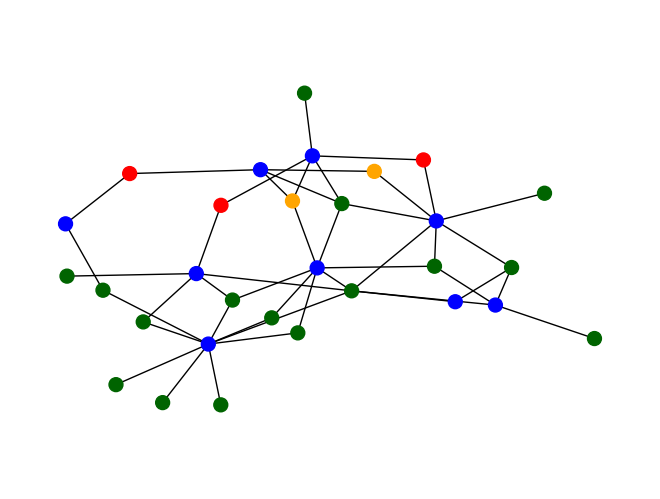

In [65]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [35]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].numpy()[ind]
Counter(list0)

Counter({0.0: 7, 1.0: 1})

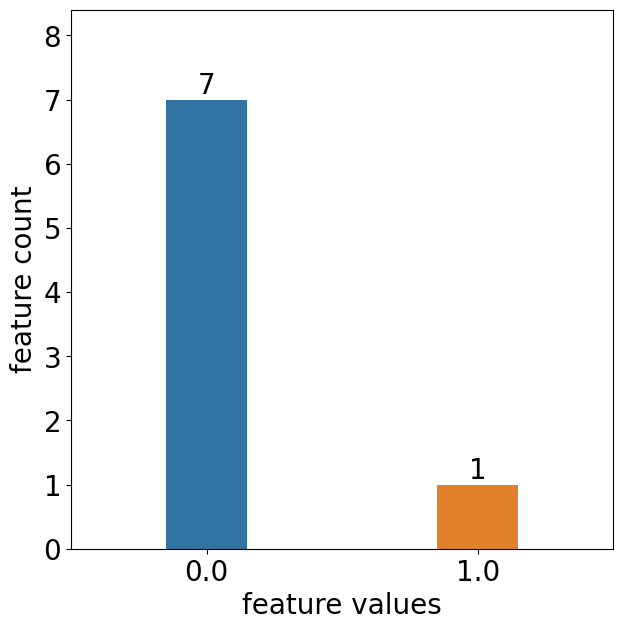

In [36]:
count_plot(list0)

Number of nodes:  20
graph id:  142
Max pred probability for class 1 is 0.5999847650527954


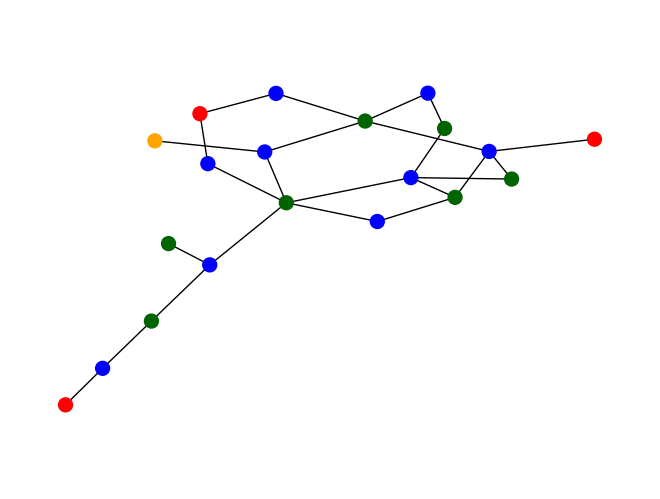

In [67]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [38]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].numpy()[ind]
Counter(list1)

Counter({0.0: 6, 1.0: 2})

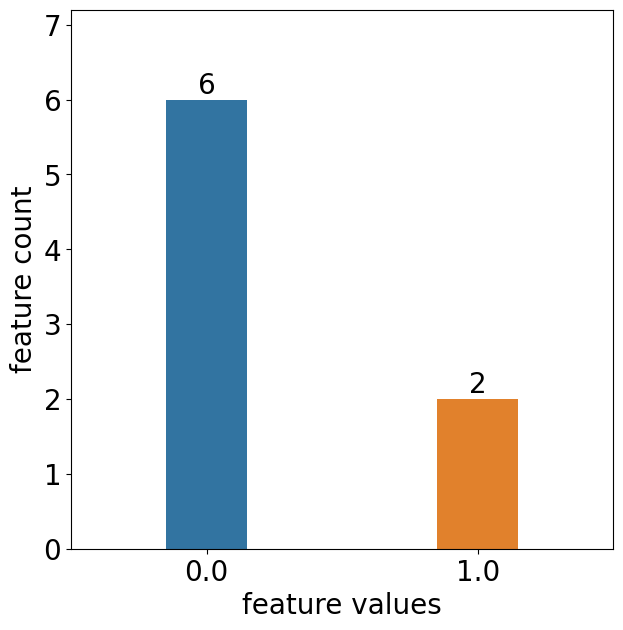

In [39]:
count_plot(list1)

Number of nodes:  25
graph id:  162
Max pred probability for class 2 is 0.9995469450950623


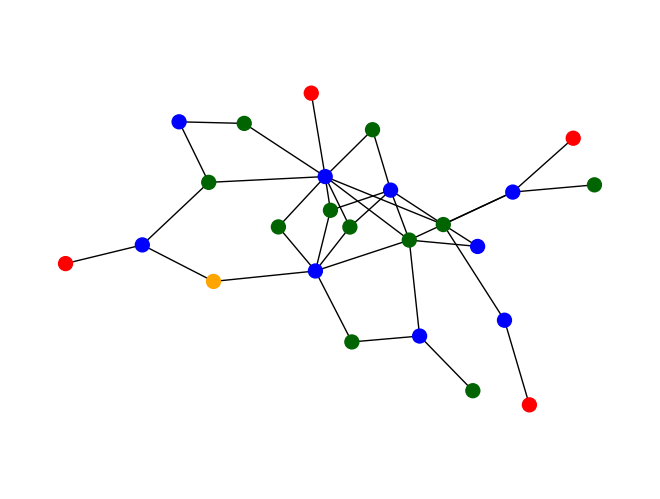

In [69]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [41]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].numpy()[ind]
Counter(list2)

Counter({0.0: 6, 1.0: 2})

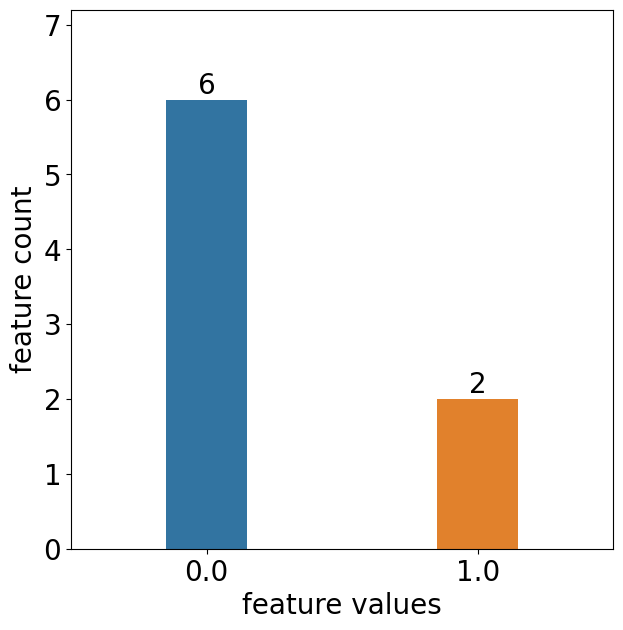

In [42]:
count_plot(list2)

Number of nodes:  25
graph id:  47
Max pred probability for class 3 is 0.9991543292999268


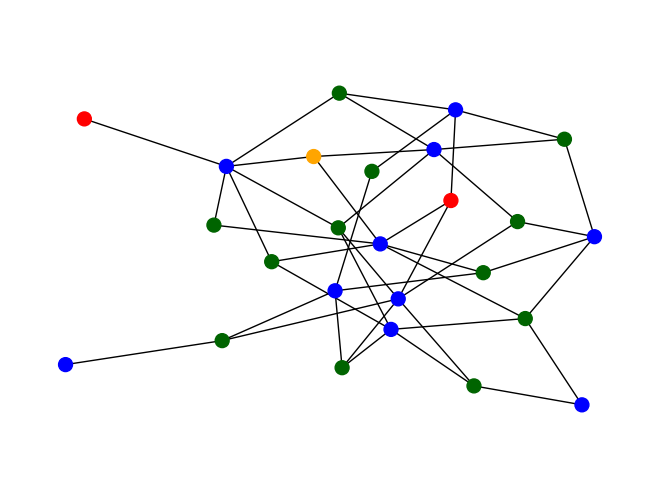

In [71]:
explanation_graph3 = plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [44]:
ind= index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].numpy()[ind]
Counter(list3)

Counter({0.0: 6, 1.0: 2})

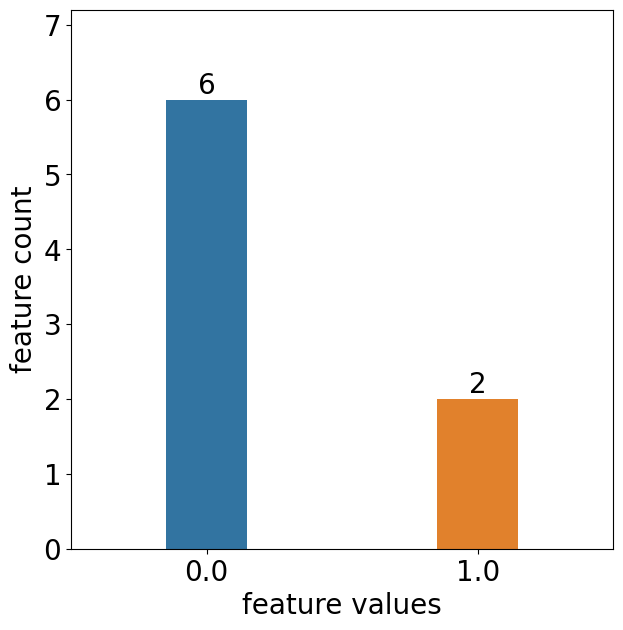

In [45]:
count_plot(list3)

In [46]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [47]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show()  

In [48]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [49]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].numpy())
print_stat_cont_features(term0_df)

mean -0.14208597
std dev 0.5475608


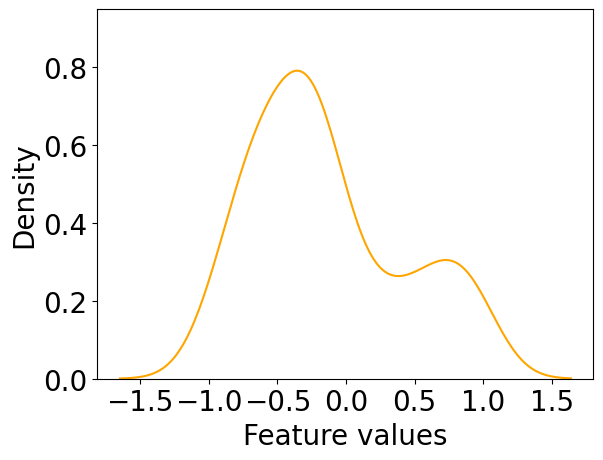

In [50]:
plot_node_feat(term0_df)

In [51]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].numpy())
print_stat_cont_features(term1_df)

mean -0.28313342
std dev 0.45278046


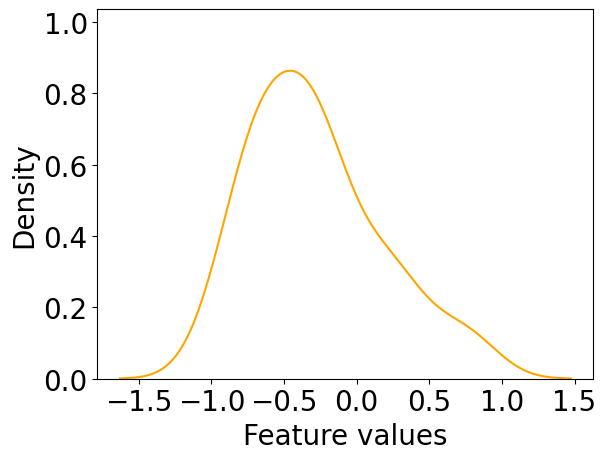

In [52]:
plot_node_feat(term1_df)

In [53]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].numpy())
print_stat_cont_features(term2_df)

mean -0.25526708
std dev 0.47204924


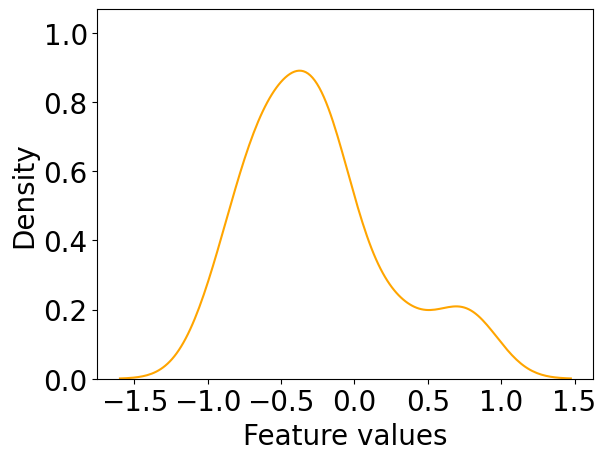

In [54]:
plot_node_feat(term2_df)

In [55]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].numpy())
print_stat_cont_features(term3_df)

mean -0.1372273
std dev 0.518756


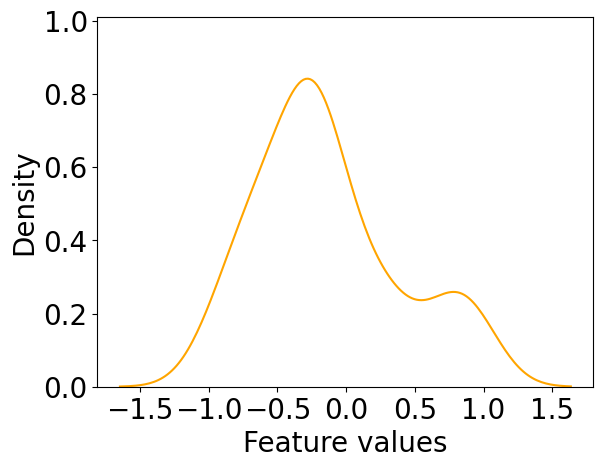

In [56]:
plot_node_feat(term3_df)

In [57]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].numpy())

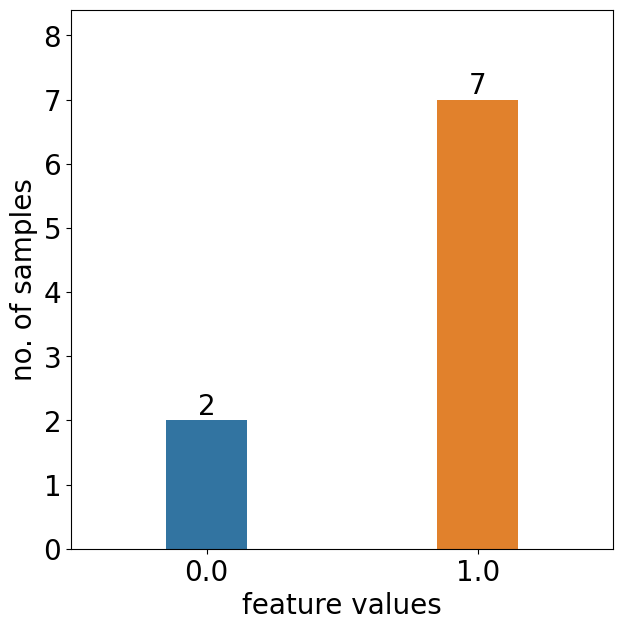

In [58]:
imp_paper_feat0=feature_selection(paper0_df)
plot_imp_feature(imp_paper_feat0.values.tolist())

In [59]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].numpy())

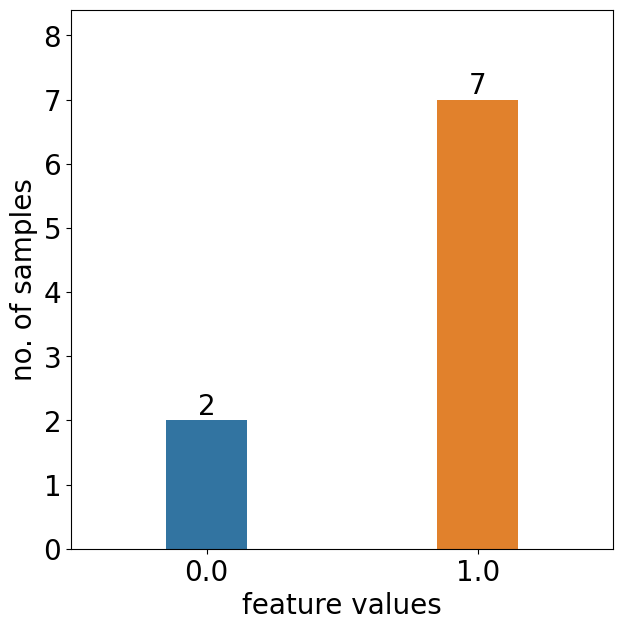

In [60]:
imp_paper_feat1=feature_selection(paper1_df)
plot_imp_feature(imp_paper_feat1.values.tolist())

In [61]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].numpy())

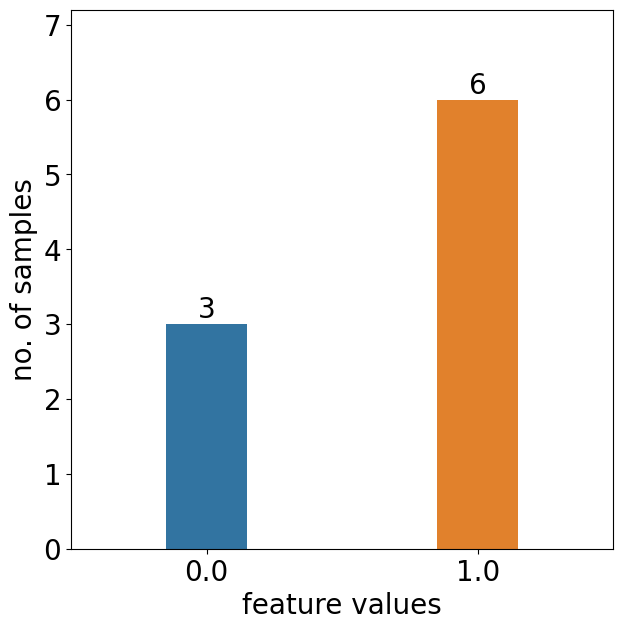

In [62]:
imp_paper_feat2=feature_selection(paper2_df)
plot_imp_feature(imp_paper_feat2.values.tolist())

In [63]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].numpy())

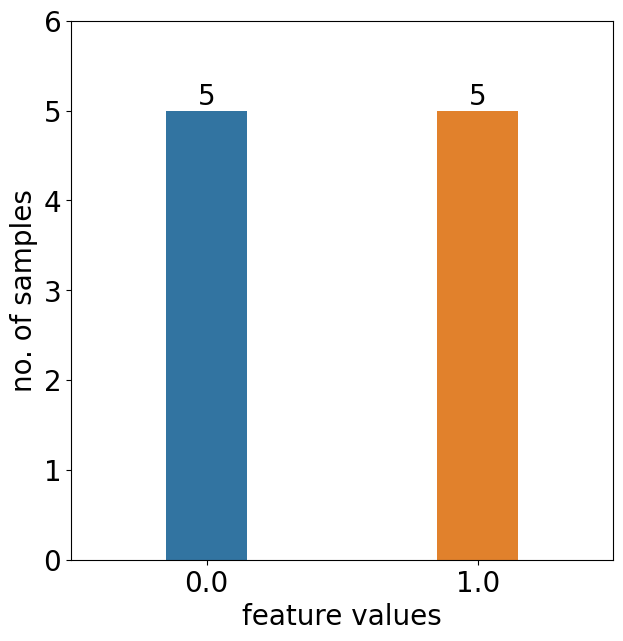

In [64]:
imp_paper_feat3=feature_selection(paper3_df)
plot_imp_feature(imp_paper_feat3.values.tolist())